# Read raw data

In [3]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Read ground truth values for all 500k images
ground_truth = np.genfromtxt('gt_train.csv', delimiter=',', dtype=['u4', 'U50'])

# Put image titles and their labels in a dictionary for easy retrieval
# Format: [imageNumber:Label]. Ex: [43123:'pedestrian']

gt = {}
for img in ground_truth:
    gt[img[0]] = img[1]

# Load 1000 grey images from each catagory and put them in the lists below
images = []
names = []
labels = []
for f in sorted(glob.glob("MIO-TCD-Classification/train/*")):
    s=0
    print(f)
    for g in sorted(glob.glob(str(f)+'/*.jpg')):
        img = cv2.imread(g, 0) # Read image in grey
        name = int(g[-12:-4]) # File name
        images.append(img)
        names.append(name)
        labels.append(gt[name])
        s += 1
        if (s == 1000):
            break
print(len(images), 'images were read with their names and labels (1000 from each catagory)')

MIO-TCD-Classification/train/articulated_truck
MIO-TCD-Classification/train/background
MIO-TCD-Classification/train/bicycle
MIO-TCD-Classification/train/bus
MIO-TCD-Classification/train/car
MIO-TCD-Classification/train/motorcycle
MIO-TCD-Classification/train/non-motorized_vehicle
MIO-TCD-Classification/train/pedestrian
MIO-TCD-Classification/train/pickup_truck
MIO-TCD-Classification/train/single_unit_truck
MIO-TCD-Classification/train/work_van
11000 images were read with their names and labels (1000 from each catagory)


# PROJECT PART 1: CLASSIFICATION

## HoG Features

In [4]:
# Function to compute hog features
def hog(img):
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                      img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,
                            block_size[0], block_size[1], nbins) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
    
    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

## Compute HoG Features

In [5]:
# Now the images are of diffrent sizes. We might need to fill the smaller images with zeros
def fill(arr, max_len):
    x = np.zeros(abs(len(arr) - max_len))
    return np.concatenate((arr,x), axis=0)

hogs_temp = []
#calculate hog for each image
max_len = 0
avg = 0
for image in images:
    #the classifier takes 2d training data. hog produces 3d so we flatten the result to make it 1d.. then we
    #group all hogs in one list to make a 2d list
    
    # [REVIEW] resize because knn expects all data to be symetric
    grad = hog(cv2.resize(image, (50, 50), interpolation=cv2.INTER_AREA)).flatten()

    avg += len(grad)
    if len(grad) > max_len:
        max_len = len(grad)
    hogs_temp.append(grad)

#convert the HoGs array to np array to be processed
hogs_temp = np.array(hogs_temp)
hogs = hogs_temp

print('Shape of the hogs list: ',hogs.shape, max_len)

Shape of the hogs list:  (11000, 1152) 1152


In [6]:
# Just to see the distrbution of the lenghts of the flat hogs (maybe we can filter out stuff)
# ONLY WORKS IF WE ARE NOT RESIZING
# from scipy import stats
# h = []
# for ho in hogs:
#     h.append(len(ho))
# h.sort()
# hmean = np.mean(h)
# hstd = np.std(h)
# pdf = stats.norm.pdf(h, hmean, hstd)
# plt.plot(h, pdf) # including h here is crucial
# print(hstd, hmean)

## Split data and Classify using KNN and SVM

In [7]:
from sklearn import svm
from sklearn.model_selection import  train_test_split 
from sklearn.neighbors import KNeighborsClassifier as knc

X_train, X_test, y_train, y_test = train_test_split(hogs, labels, test_size=0.25)

########################################################
## KNN CLASSIFIER
knn = knc(n_neighbors = 3)

knn.fit(X_train, y_train)

p = knn.predict(X_test)
########################################################


########################################################
## SVM CLASSIFIER
# https://scikit-learn.org/stable/modules/svm.html

# Create svm Linear object
lin_clf = svm.LinearSVC()

lin_clf.fit(X_train, y_train)

p_svm = lin_clf.predict(X_test)
########################################################

#### Average classification accuracy across validations, with the standard deviation.

In [8]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(knn, hogs, labels, cv=10)
print(scores1)

scores2 = cross_val_score(lin_clf, hogs, labels, cv=10)
print(scores2)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

[0.55272727 0.60090909 0.71454545 0.72272727 0.73272727 0.67727273
 0.69636364 0.67363636 0.66363636 0.67545455]
[0.46727273 0.53545455 0.59545455 0.61636364 0.62818182 0.55636364
 0.58363636 0.59363636 0.54727273 0.61454545]
Accuracy: 0.67 (+/- 0.11)
Accuracy: 0.57 (+/- 0.09)


#### Average precision and recall across validations. Are these values consistent with the accuracy? Are they more representative of the dataset? In what situations would you expect precision and recall to be a better reflection of model performance than accuracy?

In [9]:
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_recall_curve

# or use sklearn function and output average instead of list
precision_SVM = precision(y_test, p_svm, average = 'weighted')

recall_SVM = recall(y_test, p_svm, average = 'weighted')

precision_KNN = precision(y_test, p, average = 'weighted')

recall_KNN = recall(y_test, p, average = 'weighted')


print("precision_SVM",precision_SVM)

print("recall_SVM",recall_SVM)

print("precision_KNN",precision_KNN)

print("recall_KNN",recall_KNN)

precision_SVM 0.5956580987229275
recall_SVM 0.5963636363636363
precision_KNN 0.7236148876425913
recall_KNN 0.7


#### Confusion matrix on a validation set. Plot thematrix as an image. Are any of the classes dificult for your classifier? Discuss.

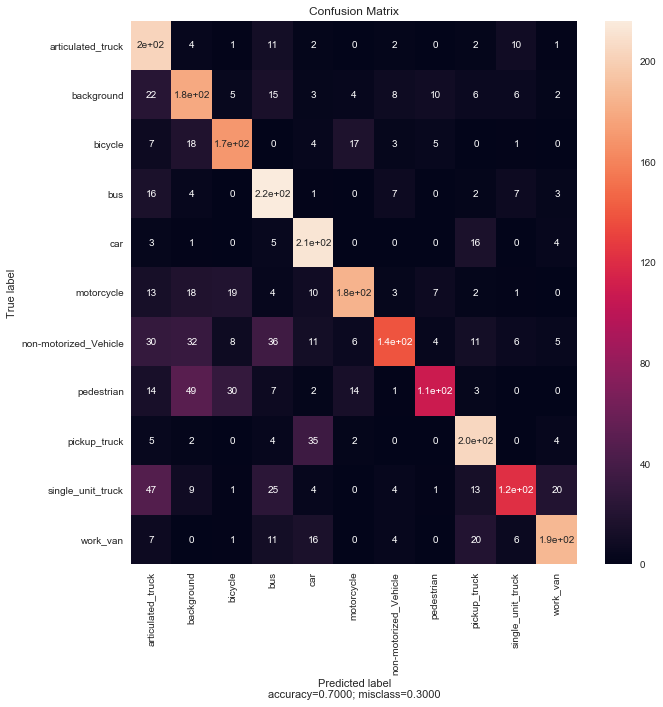

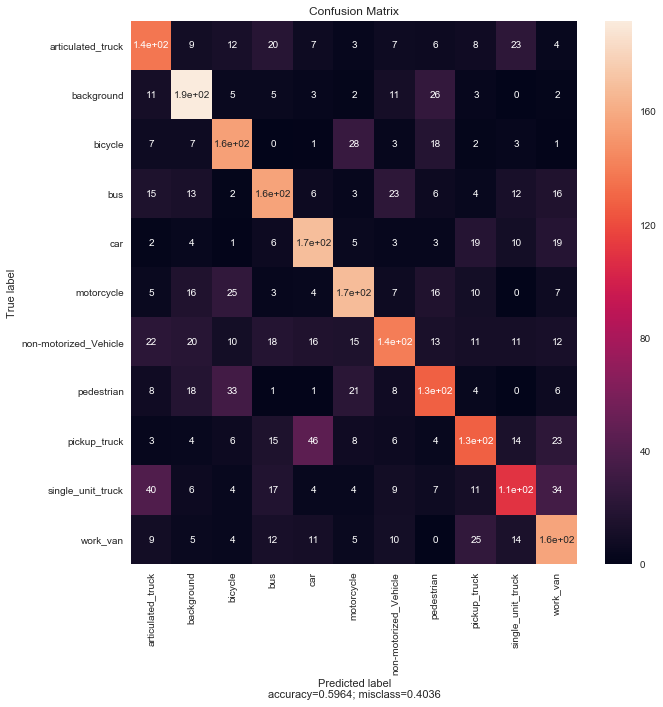

In [10]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Targets=['articulated_truck', 'background', 'bicycle', 'bus','car','motorcycle','non-motorized_Vehicle', 'pedestrian','pickup_truck', 'single_unit_truck', 'work_van']

def plot_cm(cm, indx, colomn):
    accuracy= np.trace(cm)/ float(np.sum(cm))
    misclasses= 1- accuracy
    df_cm = pd.DataFrame(cm, index = [i for i in indx],columns = [i for i in colomn])
                  
    plt.figure(figsize = (10,10))
    sn.set(font_scale=1)#for label size
    sn.heatmap(df_cm, annot=True,annot_kws={"size": 10})# font size
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclasses))


# KNN RESULTS
cnf_matrix2 = confusion_matrix(y_test, p)

plot_cm(cnf_matrix2, Targets,Targets)

# SVM RESULTS
cnf_matrix = confusion_matrix(y_test, p_svm)

plot_cm(cnf_matrix,Targets, Targets)

# PROJECT PART 2: LOCALIZATION & CLASSIFICATION

### Helper functions:

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import euclidean_distances as e_dist

# Function to calulate the intersection of union of two boxes
# Method was inspired by the official code that was provided with the dataset
def dice(bbox_1, bbox_2):
    '''
        Compute the IoU ratio between two bounding boxes
    '''

    # intersection box coords
    bi = [max(bbox_1[0], bbox_2[0]), max(bbox_1[1], bbox_2[1]),
          min(bbox_1[2], bbox_2[2]), min(bbox_1[3], bbox_2[3])]

    # width and height of intersection box
    iw = bi[2] - bi[0] + 1
    ih = bi[3] - bi[1] + 1

    ov = 0

    if iw > 0 and ih > 0:
        # ua = areaFirstBox + areaSecondBox - areaIntersection
        ua = (bbox_1[2] - bbox_1[0] + 1) * (bbox_1[3] - bbox_1[1] + 1) + \
             (bbox_2[2] - bbox_2[0] + 1) * (bbox_2[3] - bbox_2[1] + 1) - \
             iw * ih
        ov = iw * ih / float(ua)

    dice = (2 * ov) / (1 + ov)
    return dice

# In case of multiple boxes, match the boxes to maximze dice
# Run this method on every predicted box
def max_dice(boxP, boxesT):
    dices = []
    for box in boxesT:
        dices.append(dice(box, boxP))
    dices = np.array(dices)
    maxCoords = boxesT[np.argmax(dices)]
    return dices.max(), maxCoords


# function to compute hog features
def compute_hog(pictures):
    hogs_temp = []
    #calculate hog for each image
    max_len = 0
    avg = 0
    for image in pictures:
        #the classifier takes 2d training data. hog produces 3d so we flatten the result to make it 1d.. then we
        #group all hogs in one list to make a 2d list

        # [REVEIW] resize because knn expects all data to be symetric

        grad = hog(cv2.resize(image, (50, 50), interpolation=cv2.INTER_AREA)).flatten()
    #     grad = hog(image).flatten()
        avg += len(grad)
        if len(grad) > max_len:
            max_len = len(grad)
        hogs_temp.append(grad)

    #convert the HoGs array to np array to be processed
    hogs_temp = np.array(hogs_temp)
    
    hogs = hogs_temp
    print('Shape of the hogs list: ',hogs.shape, max_len)
    return hogs

def train_classifier(hog_list, label_list):
    X_train, X_test, y_train, y_test = train_test_split(hog_list, label_list, test_size=0.25)

    lin_clf = svm.LinearSVC()

    lin_clf.fit(X_train, y_train)

    p_svm = lin_clf.predict(X_test)

    # Accuracy
    k = 0
    for x in range(len(p_svm)):
        if p_svm[x] == y_test[x]:
            k += 1
    print('Accuracy of SVM is', k, 'out of', len(X_test), ', percentage: %', 100*k/len(X_test))
    
    return lin_clf

def detection(hog_list):
    pred_back=[]
    p= np.array(bkg_classifer.predict(hog_list)) 
    pred=0
    for i in range(len(p)):
        
        if p[i] != 'background':
            pred= i
            pred_back.append(pred)
            
            
            
    pred_back= np.array(pred_back)
    return pred_back

def kmean(datas,k):
    data= np.float32(datas)
# before calling openCV's kmeans, we need to specify the stop criteria
# stop when either 100 iterations or an accuracy of 1 is reached
# define criteria = (type, max_iter=100, epsilon=1.0)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1.0)

# set number of clusters
    K = k

# apply Kmeans
# cv2.kmeans(data, K, bestLabels, criteria, attempts, flags[, centers]) → retval, bestLabels, centers
# compactness: the sum of squared distance from each point to their corresponding centers
# labels: the label array (each element marked '0', '1', '2', etc.)
# centers: array of centers of clusters
    compactness, labels, centers = cv2.kmeans(data, K, None, criteria, 100, flags=cv2.KMEANS_RANDOM_CENTERS)
    
    return centers


def s_window(image,k):
    hogs_new = []
    max_len = 0
    avg = 0
    coord=[]
    size=[20,50,100,200]
    for value in size:
        for x in range(0,image.shape[1],20):
            for y in range(0,image.shape[0],20):
                sub = cv2.resize(image[y:y+value, x:x+value], (100,100))
                c= [x,y, value]
                coord.append(c)
                gradi = hog(cv2.resize(sub, (50, 50), interpolation=cv2.INTER_AREA)).flatten()


    #     grad = hog(image).flatten()
                avg += len(gradi)
                if len(gradi) > max_len:
                      max_len = len(gradi)
                hogs_new.append(gradi)

    #convert the HoGs array to np array to be processed
    hogs_new = np.array(hogs_new)
    print('Hog features detected = ',len(hogs_new))
    # hogs = hogs_new

    d= detection(hogs_new)
    print('Number of windows selected from HoG list =', len(d))

    rect=[]
    b_rect=[]
    for value in d:
        cpoint= coord[value]
        rect.append(cpoint)
    rect= np.array(rect)
    for pt in rect:
            box= [pt[0],pt[1],pt[0]+pt[2]+50,pt[1]+pt[2]]
            b_rect.append(box)
    b_rect= np.array(b_rect)
    
    coordinate= kmean(b_rect,k)
    
    b=[]
    for pts in coordinate:
        box= [pts[0], pts[1], pts[2], pts[3]]
        print('Box found with coordinate= ', box )
        b.append(box)
    b= np.array(b)
    
    return b, b_rect


def plot_boxes(image, coordinates):
    im_copy= image.copy()
    for pts in coordinates:
        boxes= cv2.rectangle(im_copy, (pts[0],pts[1]), (pts[2], pts[3]), (255,255,0), 5)
    boxes= cv2.cvtColor(boxes, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.subplot(111), plt.imshow(boxes, )
    plt.title("Bounding Boxes"), plt.xticks([]), plt.yticks([])# Find distance between two boxes

def box_distance(box1, box2):
    # center of each box
    cx1, cy1 = box1[0] + (box1[2]-box1[0]/2), box1[1] + (box1[3]-box1[1]/2)
    cx2, cy2 = box2[0] + (box2[2]-box2[0]/2), box2[1] + (box2[3]-box2[1]/2)
    
    point = [[cx1-cx2 , cy1-cy2]]
    point1= [[cx1,cy1]]
    point2=[[cx2,cy2]]
    # distance between centers
    dist = dist= np.sqrt(((cx2-cx1)**2)+(cy2-cy1)**2)
    
    return dist
    
# Merge boxes that are at a certain threshold from the mean box
def merge_boxes(mean, boxes):
    # Threshold is height or width of the mean box, the longest of them
    threshold = int((max(mean[2]-mean[0], mean[3]-mean[1]))*3)
    close_boxes = []
    for box in boxes:
        d = box_distance(mean, box)
        if d < threshold:
            close_boxes.append(box)
    
    # Find the smallest upper left corner and largest lower right corner
    upper_lefts = np.array(close_boxes)[:,:2]
    lower_rights = np.array(close_boxes)[:,2:4]

    UL = upper_lefts.min(axis = 0) #min upper left
    LR = lower_rights.max(axis = 0) #max lower right
    
    merged = [UL[0], UL[1], LR[0], LR[1]]
    
    return merged
def final_boxes(listt):
    final_box = []
    for h in listt:
        m = merge_boxes(h, listt)
        final_box.append(m)
    final_box= np.array(final_box)
    return final_box

### Train classifier to identify objects on backgrounds

In [12]:
# This will train a classifier to recorgnize backgroud images from foreground
# Only two classes are used here, positives and negative, positives are
# foreground images while negatives are background images. 

# Read ground truth values for all 500k images
ground_truth = np.genfromtxt('gt_train.csv', delimiter=',', dtype=['u4', 'U50'])

# Put image titles and their labels in a dictionary for easy retrieval
# Format: [imageNumber:Label]. Ex: [43123:'pedestrian']

gt = {}
for img in ground_truth:
    gt[img[0]] = img[1]
    

# Load 1000 grey images from each catagory and put them in the lists below
images = []
names = []
labels = []
for f in sorted(glob.glob("MIO-TCD-Classification/abc/*")):
    s=0
    for g in sorted(glob.glob(str(f)+'/*.jpg')):
        img = cv2.imread(g, 0) # Read image in grey
        name = int(g[-12:-4]) # File name
        images.append(img)
        names.append(name)
        labels.append(gt[name])
        
print(len(images), 'images were read with their names and labels')

h_list= compute_hog(images)
#
bkg_classifer= train_classifier(h_list,labels)

14175 images were read with their names and labels
Shape of the hogs list:  (14175, 1152) 1152
Accuracy of SVM is 2884 out of 3544 , percentage: % 81.37697516930022


### Test on an image

In [13]:
##LOAD IMAGE 
img= cv2.imread("MIO-TCD-Localization/train/00000027.jpg", cv2.COLOR_BGR2RGB)
# img_gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# hog, all_boxes = s_window(img_gray,3)
# final= final_boxes(hog)
# bounding_boxes= plot_boxes(img,hog)


# plot_boxes(img, final)

# bounding_boxes= plot_boxes(img,hog)

# final_boxes = []
# for h in hog:
#     m = merge_boxes(h, hog)
#     final_boxes.append(m)
# plot_boxes(img, final_boxes)

def main(img):
    img_gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog, all_boxes = s_window(img_gray,3)
    final= final_boxes(hog)
#     plot_boxes(img, final)
    return final

In [14]:
# Get all ground truth boxes for an image:
def image_gt(gtl, image_id):
    truths = []
    for g in gtl:
        if image_id == g[0]:
            truths.append(list(g)[1:])
        if (g[0] > image_id):
            break
    return truths 

# Load ground truths
gtl = np.genfromtxt('MIO-TCD-Localization/gt_train.csv', delimiter=',', dtype=['u4', 'U50', 'u4', 'u4', 'u4', 'u4'])

training_addresses = sorted(glob.glob("MIO-TCD-Localization/train/*.jpg"))[:50]
local_images = []
images_truths = [] # has truths of all images (array of arrays of different sizes)
i = 0
# name of the image is its index
for f in training_addresses:
    im = cv2.imread(f)
    local_images.append(im)
    images_truths.append(image_gt(gtl,i))
    i += 1
    
found_boxes = []
for im in local_images:
    f = main(im)
    found_boxes.append(f)
found_boxes = np.array(found_boxes)

Hog features detected =  864
Number of windows selected from HoG list = 28
Box found with coordinate=  [254.0, 178.0, 359.0, 233.0]
Box found with coordinate=  [246.0, 32.0, 357.0, 93.0]
Box found with coordinate=  [55.0, 57.5, 163.75, 116.25]
Hog features detected =  3456
Number of windows selected from HoG list = 159
Box found with coordinate=  [305.9375, 134.375, 495.15625, 273.59375]
Box found with coordinate=  [129.30232, 113.95349, 290.0, 224.65117]
Box found with coordinate=  [513.07697, 174.23077, 697.88464, 309.03848]
Hog features detected =  3456
Number of windows selected from HoG list = 108
Box found with coordinate=  [247.16982, 105.28302, 417.16983, 225.28302]
Box found with coordinate=  [476.2963, 61.481483, 653.70374, 188.88889]
Box found with coordinate=  [455.00003, 353.57144, 637.8572, 486.4286]
Hog features detected =  3456
Number of windows selected from HoG list = 89
Box found with coordinate=  [103.571434, 129.28572, 276.78574, 252.50002]
Box found with coordinat

Hog features detected =  3456
Number of windows selected from HoG list = 172
Box found with coordinate=  [330.8046, 288.50574, 524.5977, 432.29886]
Box found with coordinate=  [67.741936, 131.6129, 224.51613, 238.38708]
Box found with coordinate=  [557.3913, 58.26087, 720.4348, 171.30435]
Hog features detected =  3456
Number of windows selected from HoG list = 95
Box found with coordinate=  [125.0, 108.333336, 234.16667, 167.5]
Box found with coordinate=  [548.75, 249.375, 740.9375, 391.5625]
Box found with coordinate=  [438.82355, 74.5098, 633.13727, 218.82353]
Hog features detected =  864
Number of windows selected from HoG list = 35
Box found with coordinate=  [143.07693, 84.61539, 270.76923, 162.3077]
Box found with coordinate=  [246.15385, 178.46155, 375.38464, 257.69232]
Box found with coordinate=  [20.0, 64.44444, 121.111115, 115.55556]
Hog features detected =  3456
Number of windows selected from HoG list = 81
Box found with coordinate=  [175.625, 320.625, 382.1875, 477.1875]
B

In [15]:
coords = np.array(images_truths[3])[:,1:]
coords = coords.astype(np.int)
print(coords)
print(images_truths[0])

[[480  99 511 120]
 [257 199 369 280]]
[['pickup_truck', 213, 34, 255, 50], ['car', 194, 78, 273, 122], ['car', 155, 27, 183, 35], ['articulated_truck', 43, 25, 109, 55], ['car', 106, 32, 124, 45]]


In [16]:
for bo in found_boxes[3]:
    print(max_dice(bo,coords))

(0.2054806603018816, array([257, 199, 369, 280]))
(0.10314118069593523, array([257, 199, 369, 280]))
(0.12911961329088864, array([257, 199, 369, 280]))


In [64]:
def equal_lists(list1, list2):
    for i in range(len(list1)):
        if(int(list1[i]) != int(list2[i])):
            return False
    return True


def predict_patch(box, image):
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
    sub = image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]
    grad = hog(cv2.resize(sub, (50, 50), interpolation=cv2.INTER_AREA)).flatten()
    grad = grad.reshape(1, -1)
    prediction = knn.predict(grad)
    return prediction

def get_true_prediction(box, boxesT):
    pred = 'unknown'
    for b in boxesT:
        print("b", b)
        boxes = np.array(b)[1:]
        boxes = boxes.astype(np.int)
        if(equal_lists(box,boxes)):
            pred = b[0]
    return pred

all_dices = []
total_preds = 0
good_preds = 0
bad_preds = 0
our_preds = []
true_preds = []
#### THIS IS THE LOOP THAT FINDS DICES AND PREDECTIONS
for i, found in enumerate(found_boxes):
    img = local_images[i]
    coords = np.array(images_truths[i])[:,1:]
    coords = coords.astype(np.int)
    print("box number", i)
    for box in found:
        d, maxCoords = max_dice(box,coords)
        if(d != 0):
            total_preds += 1
            all_dices.append(d)
            truePred = get_true_prediction(list(maxCoords), images_truths[i])
            true_preds.append(truePred)
            ourPred = predict_patch(box,img)[0]
            our_preds.append(ourPred)
            if truePred == ourPred:
                good_preds += 1
            else:
                bad_preds += 1
all_dices = np.array(all_dices)

box number 0
b ['pickup_truck', 213, 34, 255, 50]
b ['car', 194, 78, 273, 122]
b ['car', 155, 27, 183, 35]
b ['articulated_truck', 43, 25, 109, 55]
b ['car', 106, 32, 124, 45]
b ['pickup_truck', 213, 34, 255, 50]
b ['car', 194, 78, 273, 122]
b ['car', 155, 27, 183, 35]
b ['articulated_truck', 43, 25, 109, 55]
b ['car', 106, 32, 124, 45]
b ['pickup_truck', 213, 34, 255, 50]
b ['car', 194, 78, 273, 122]
b ['car', 155, 27, 183, 35]
b ['articulated_truck', 43, 25, 109, 55]
b ['car', 106, 32, 124, 45]
box number 1
b ['bus', 205, 155, 568, 314]
b ['bus', 285, 123, 477, 168]
b ['car', 544, 162, 617, 193]
b ['car', 329, 152, 371, 163]
b ['car', 447, 161, 497, 183]
b ['car', 662, 199, 715, 236]
b ['bus', 205, 155, 568, 314]
b ['bus', 285, 123, 477, 168]
b ['car', 544, 162, 617, 193]
b ['car', 329, 152, 371, 163]
b ['car', 447, 161, 497, 183]
b ['car', 662, 199, 715, 236]
b ['bus', 205, 155, 568, 314]
b ['bus', 285, 123, 477, 168]
b ['car', 544, 162, 617, 193]
b ['car', 329, 152, 371, 163]
b ['c

b ['car', 228, 44, 291, 68]
b ['car', 511, 135, 632, 200]
b ['car', 623, 81, 663, 100]
box number 33
b ['pickup_truck', 209, 48, 318, 96]
b ['pickup_truck', 209, 48, 318, 96]
box number 34
b ['car', 91, 126, 160, 168]
box number 35
b ['car', 194, 1, 244, 38]
b ['single_unit_truck', 432, 173, 711, 336]
box number 36
b ['car', 3, 92, 106, 150]
b ['car', 169, 49, 275, 97]
b ['car', 3, 92, 106, 150]
b ['car', 169, 49, 275, 97]
b ['car', 3, 92, 106, 150]
b ['car', 169, 49, 275, 97]
box number 37
b ['pickup_truck', 138, 47, 260, 97]
b ['pickup_truck', 138, 47, 260, 97]
b ['pickup_truck', 138, 47, 260, 97]
box number 38
b ['car', 76, 122, 240, 208]
b ['car', 76, 122, 240, 208]
box number 39
b ['car', 156, 26, 180, 37]
b ['pickup_truck', 212, 34, 253, 52]
b ['pickup_truck', 242, 90, 338, 150]
b ['car', 150, 49, 184, 67]
b ['car', 156, 26, 180, 37]
b ['pickup_truck', 212, 34, 253, 52]
b ['pickup_truck', 242, 90, 338, 150]
b ['car', 150, 49, 184, 67]
b ['car', 156, 26, 180, 37]
b ['pickup_truck'

#### Compute the DICE coeficient for the predicted vs. true bounding boxes (for multiple boxes in one image, match the boxes to maximize the mean DICE).

Refer to the two methods dice() and max_dice() for details on how to the results were found.

We iterated over all the localized boxes and found their max DICE. All of the max DICEs were put in one array 'all_dices' then we found the mean of that array.

In [65]:
print('Mean MAXIMIZED DICE for all validations:', all_dices.mean())
print(len(all_dices))

Mean MAXIMIZED DICE for all validations: 0.26240103813269766
121


#### Report the distribution of DICE coeficients over your validation sets.

[0.31168618 0.3546271  0.2139394  0.31148627 0.24655048 0.34618015
 0.20941662 0.20049391 0.28709769 0.13842547]


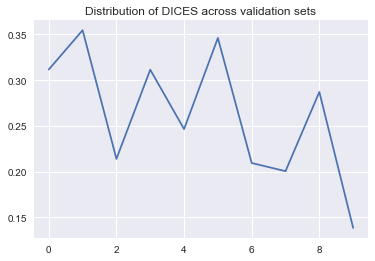

In [78]:
split_dices = np.array_split(np.array(all_dices),10)
means = []

for split in split_dices:
    means.append(np.array(split).mean())
means = np.array(means)

print(means)

plt.plot(means); plt.title("Distribution of DICES across validation sets")
plt.xtitle("")plt.show()

#### Use the localization predicted by your localizer to evaluate your classifier from Section 2. Compare the accuracy, prediction, and recall of using your localizer + classifier vs. using the classification data + classifier. Is there a difference, and why/why not? Should the 'background' label of the classifier be included when evaluating the performance of the localizer, and why/why not?

As seen in the numbers below, our accuracy, predictions, and recall are relativly low. This is expected because our localizer had a mean DICE coefficient of less than 20% in best cases. When looking at the generated boxes in the images, we can see that there's at least one box that localized on or near an object. Sometime this box will not cover the whole object so when we sent it through the classifier it will predict a wrong result. Since our non-deep learning localizer performed realitivly well (70% accuracy), we expect it to perform well at least here if the localization was accurate.

Should background label be included? We think no. To begin with, we train our localizer to distinguish between background and not-background. Every box should localize around an object that is not a background. Now the box might be correctly around an object, but for some reason the classifier predicts a "background" for that object. This is why we this background shouldn't be included, because sometimes the localizer is correct, but because of the accuracy of the classifier we get a bad result to what should've been a good result.

In [58]:
import warnings
warnings.filterwarnings('ignore')

# or use sklearn function and output average instead of list
localize_pred_precision = precision(true_preds, our_preds, average = 'weighted')

localize_pred_recall = recall(true_preds, our_preds, average = 'weighted')

print("Accuracy %", 100 * good_preds/total_preds)
print("Precision %", 100 * localize_pred_precision)
print("Recall %", 100 * localize_pred_recall)

Accuracy % 4.166666666666667
Precision % 23.11111111111111
Recall % 4.166666666666666
